# 인공지능 과제 2
---
이름: 김태산

학과: 자동차공학과

학번: 20143211

---
### 1. [영상 인식] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

In [ ]:
# 관련 라이브러리 import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# cuda 사용 여부를 판단하여 Boolean 값을 지정한다.
is_cuda = False
if torch.cuda.is_available():
  is_cuda = True

# 데이터를 전처리하기 위한 코드로, transforms의 Compose로 전처리 과정에 포함시킬 인자를 지정한다.
# transforms.ToTensor()는 PIL Image나 numpy.ndarray를 텐서로 변환한다.
# transforms.Normalize()는 텐서 형태의 이미지를 평균(첫번째 인자, 0.1307)과
#  표준편차(두번째 인자, 0.3081)를 이용하여 정규화한다.
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# torchvision.datasets을 통해 다양한 데이터셋을 손쉽게 가져와 사용할 수 있다.
# train=True로 지정할 경우 훈련 데이터셋을, False로 지정할 경우 테스트 데이터셋을 불러온다.
# transform 파라미터를 통해 데이터 전처리 과정을 입력할 수 있다.
# download=True일 경우 첫번째 파라미터로 지정한 디렉토리에 데이터를 다운로드하여 사용할 수 있다.
train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)

# torch.utils.data.DataLoader는 데이터셋을 배치 사이즈만큼 iterable하게 불러올 수 있게 해주는 클래스이다.
# 첫번째 인자로 사용할 데이터셋을 입력하고, 
# batch_size 파라미터를 통해 매 에포크마다 사용할 미니배치의 사이즈를 지정한다.
# shuffle=True로 지정할 경우 매 에포크마다 데이터셋을 무작위하게 섞은 후 미니배치로 뽑아준다.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


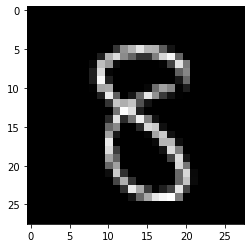

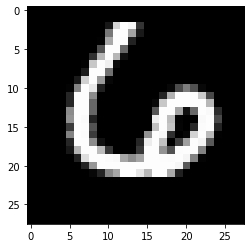

In [ ]:
# 훈련 데이터셋에서 샘플을 뽑아서 확인하기 위한 코드이다.
# train_loader는 미니배치 단위로 샘플을 뽑기 때문에 sample_data에는 32장의 이미지 데이터가 입력된다.
sample_data = next(iter(train_loader))

# 이미지를 시각화하기 위한 함수를 정의한다.
def plot_img(image):
  # 이미지는 텐서 형태이므로 이를 시각화하기 위해서 먼저 Numpy로 변환해준다.
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((std * image) + mean) # 이미지가 정규화를 통해 전처리된 상태이므로 
                                 # 이를 다시 기존의 이미지 데이터로 변환한다.
  plt.imshow(image, cmap='gray') # 이미지를 그레이 스케일로 시각화한다.
  plt.show()
  
plot_img(sample_data[0][2]) # 32장의 이미지 중 3번째 이미지를 가져와 시각화한다.
plot_img(sample_data[0][1]) # 32장의 이미지 중 2번째 이미지를 가져와 시각화한다.

# (1) 화면 출력 확인

- 출력 결과를 보면, MNIST 데이터셋의 이미지 중 하나를 불러와 plot_img 함수를 통해 시각화하는 것을 알 수 있다.

In [ ]:
# 신경망의 클래스를 구현하는 코드로, 모든 신경망 모듈의 기반 클래스인 nn.Module을 상속 받아 신경망을 사용한다.
class Net(nn.Module):
  # 신경망 모델의 초기 생성자를 정의한다.
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # 첫번째 CNN을 정의한다.
                                                  # 이미지 하나를 입력 받아 10개 채널의 특징맵을 출력한다.
                                                  # 5 * 5 사이즈의 커널을 사용한다.
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 두번째 CNN을 정의한다.
                                                  # 10개 채널의 특징맵에서 20개 채널의 특징맵을 출력한다.
                                                  # 5 * 5 사이즈의 커널을 사용한다.
    self.conv2_drop = nn.Dropout2d(p=0.1)         # 드롭아웃을 정의한다.
                                                  # p=0.1이므로 신경망에서 90%의 노드만 연결한다.
    self.fc1 = nn.Linear(320, 50)                 # 첫번째 완전연결층을 정의한다.
    self.fc2 = nn.Linear(50, 10)                  # 두번째 완전연결층을 정의한다.
                                                  # MNIST 데이터셋의 클래스는 0~9까지 총 10개이므로
                                                  # 클래스의 갯수만큼 값을 출력한다.

  # 전방 전파 메서드를 정의한다.
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 데이터를 첫번째 CNN층에 입력하고 2 * 2 사이즈의 커널을 사용하여
                                               # 최대 풀링을 적용한 후 relu 함수에 통과시킨다.
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
                                               # 데이터를 두번째 CNN층에 입력하고 2 * 2 사이즈의 커널을 사용하여
                                               # 최대 풀링을 적용한 후 relu 함수에 통과시킨다.
    x = x.view(-1, 320) # 데이터를 완전연결층에 입력하기 위해 먼저 데이터를 flatten 한다.
                        # 320은 10개의 클래스가 미니배치 단위인 32개의 이미지에 대해 계산하여 나온 숫자이다.
    x = F.relu(self.fc1(x))        # flatten한 데이터를 첫번째 완전연결층에 입력한 후 relu 함수에 통과시킨다.
    # x = F.dropout(x, p=0.1, training=self.training)
    x = self.fc2(x)                # 데이터를 두번째 완전연결층에 입력한다.
    return F.log_softmax(x, dim=1) # 신경망에서 출력된 결과를 확률값으로 만들고 log를 취해주는
                                   # log_softmax 함수를 적용하여 리턴한다.
# 신경망 객체를 생성한다.
model = Net()
# cuda가 사용 가능하면 신경망 객체를 cuda로 넘겨준다.
if is_cuda:
  model.cuda()

# SGD optimizer를 학습률 0.001로 지정하여 생성한다.
optimizer = optim.SGD(model.parameters(), lr=0.001)
# 하나의 미니배치만 학습시키기 위해 미니배치를 불러와 이미지와 label로 나누어 입력한다.
data, target = next(iter(train_loader))
# data로 cuda로 넘겨준 후 Variable에 입력하면 data의 requires_grad를 True로 지정한다.
# 이를 신경망 모델에 통과시키면 미니배치 단위로 모델이 예측한 확률값이 리턴된다.
# 그러나 과제를 하는 시점에서 pytorch docs를 확인해보면, Variable은 더 이상 사용하지 않는다고 되어 있다.
output = model(Variable(data.cuda()))

# (2) output.size(), target.size() 출력 확인
print("output:", output.size(), "\ntarget:", target.size())

output: torch.Size([32, 10]) 
target: torch.Size([32])


- 출력 결과를 보면, output의 크기는 32 * 10이고 target의 크기는 32인 것을 알 수 있다.
- output은 하나의 미니배치(이미지 32장)에 대해서 총 10개의 클래스에 대한 확률값을 계산한 결과이기 때문에 32 * 10의 크기를 가진다.
- target은 동일한 32장의 이미지의 label 값이기 때문에 미니배치 단위만큼의 크기인 것을 알 수 있다.

In [ ]:
# 신경망 모델을 훈련시키거나 평가(validation)하는 함수를 정의한다.
def fit(epoch, model, data_loader, phase='training', volatile=False):
  # phase가 'training'일 경우 신경망을 train 모드로 만든다.
  if phase == 'training':
    model.train()
  # phase가 'validation'일 경우 신경망을 evaluation 모드로 만든다.
  if phase == 'validation':
    model.eval()
    volatile = True
  
  running_loss = 0.0  # 미니배치 단위로 모델을 학습시킬 때마다 계산된 loss와
  running_correct = 0 # 정확하게 예측한 이미지의 갯수를 누적시키기 위한 변수이다.

  # 미니배치 단위로 데이터를 불러와 for문을 통해 모델을 학습시킨다.
  for batch_idx, (data, target) in enumerate(data_loader):
    if is_cuda:
      data, target = data.cuda(), target.cuda()
    
    data, target = Variable(data, volatile), Variable(target)

    # training 모드일 경우 훈련을 반복할 때마다 optimizer의 그레디언트를 초기화한다.
    if phase == 'training':
      optimizer.zero_grad()
    
    # 이미지 데이터를 모델에 통과시켜 클래스에 대한 확률값을 계산한다.
    output = model(data)
    # loss를 계산할 때에는 손실함수로 negative log likelyhood를 사용한다.
    loss = F.nll_loss(output, target)

    # 미니배치에서 매 이미지마다 계산된 nll_loss 값을 누적한다.
    # size_average를 False로 지정할 경우 미니배치에서 매 이미지마다 계산된 loss 값을
    # 미니배치 단위로 평균하지 않고 loss 값을 합한다.
    # 그러나 과제를 하는 시점에서 pytorch docs를 확인해보면, size_average는 더 이상 사용하지 않는다고 한다.
    # 대신 파라미터로 reduction='sum'을 입력해주면 같은 결과가 리턴된다.
    running_loss += F.nll_loss(output, target, size_average=False).item() # data[0]

    # output의 가장 큰 확률값에 해당하는 인덱스를 모델이 예측한 클래스로 사용한다.
    # torch.max 함수에서 dim=1로 지정할 경우 행 방향으로 최댓값을 찾고, (최댓값, 인덱스) 형태로 값을 리턴한다.
    preds = output.data.max(dim=1, keepdim=True)[1]

    # torch.eq는 element-wise로 두 텐서의 값이 같은지 비교하여 같은 크기로 같으면 True, 다르면 False을 리턴한다.
    # torch.tensor.view_as는 코드에서 target의 크기를 preds와 같은 크기로 변환한다.
    # torch.eq를 통해 preds와 target이 같은지를 비교한 후, 같은 것의 갯수를 합하여 renning_correct에 누적한다.
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()

    # training 모드일 경우, backward()하여 오류 역전파를 수행하고,
    # optimizer.step()을 통해 가중치를 갱신한다.
    if phase == 'training':
      loss.backward()
      optimizer.step()
    
  # 모델을 전체 데이터에 대해 학습시켜 누적된 running_loss를 데이터셋의 전체 길이(이미지 전체 갯수)로 나누면
  # 전체 데이터에 대해 1회 학습 후의 loss 값을 계산할 수 있다.
  loss = running_loss / len(data_loader.dataset)
  # 마찬가지로 running_correct를 데이터셋의 전체 길이(이미지 전체 갯수)로 나누면
  # 전체 데이터에 대해 1회 학습 후의 모델의 accuracy 값을 계산할 수 있다.
  accuracy = 100. * running_correct / len(data_loader.dataset)

  # 계산된 loss와 accuracy를 출력하고 이를 리턴한다.
  print(f"{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct} / {len(data_loader.dataset)}{accuracy:{10}.{4}}")
  return loss, accuracy

In [ ]:
# 모델을 훈련할 때 매 에포크마다 계산된 loss와 accuracy를 append하기 위한 빈 리스트를 생성한다.
train_losses, train_accuracy = [], []
# 모델을 테스트할 때 매 에포크마다 계산된 loss와 accuracy를 append하기 위한 빈 리스트를 생성한다.
val_losses, val_accuracy = [], []

# 모델을 총 19 epoch 동안 학습시킨다.
for epoch in range(1, 20):
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')

  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)

  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

# (3) 화면 출력 확인

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   1.9 and training accuracy is 27320 / 60000     45.53
validation loss is  0.96 and validation accuracy is 8001 / 10000     80.01
training loss is  0.53 and training accuracy is 51489 / 60000     85.82
validation loss is  0.31 and validation accuracy is 9075 / 10000     90.75
training loss is  0.32 and training accuracy is 54377 / 60000     90.63
validation loss is  0.24 and validation accuracy is 9270 / 10000      92.7
training loss is  0.26 and training accuracy is 55390 / 60000     92.32
validation loss is   0.2 and validation accuracy is 9390 / 10000      93.9
training loss is  0.22 and training accuracy is 56003 / 60000     93.34
validation loss is  0.18 and validation accuracy is 9474 / 10000     94.74
training loss is   0.2 and training accuracy is 56468 / 60000     94.11
validation loss is  0.16 and validation accuracy is 9521 / 10000     95.21
training loss is  0.18 and training accuracy is 56775 / 60000     94.62
validation loss is  0.14 and validation accura

- 출력 결과를 보면, 훈련이 진행될수록 training loss는 감소하고 training accuracy는 증가하므로 신경망 모델의 훈련이 잘 진행되는 것을 알 수 있다.
- 또한, 매 epoch마다 모델을 훈련 시킨 후, test dataset을 모델에 통과시킨 결과를 보면 마찬가지로 훈련이 진행될수록 validation loss는 감소하고 validation accuracy는 증가하므로 모델의 일반화 성능이 점진적으로 증가하는 것을 알 수 있다.
- 마지막 epoch가 종료된 후의 validation accuracy는 97.96% 정도로 매우 높은 일반화 성능을 보이는 것을 알 수 있다.

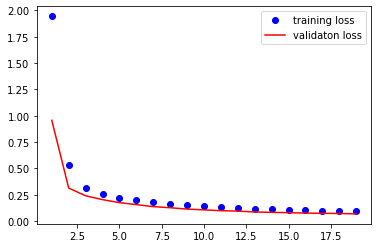

In [ ]:
# (4) 화면 출력 확인
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label='training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='validaton loss')
plt.legend()
plt.show()

- 위의 그래프는 매 epoch마다 모델의 training loss와 validation loss를 시각화한 것이다.
- epoch가 증가할수록 training loss와 validation loss가 모두 감소하므로 모델이 training dataset에 과대적합되지 않고 훈련이 잘 진행되는 것을 알 수 있다.

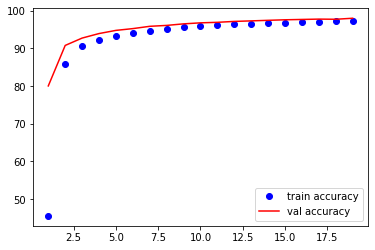

In [ ]:
# (5) 화면 출력 확인
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'bo', label='train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'r', label='val accuracy')
plt.legend()
plt.show()

- 위의 그래프는 매 epoch마다 모델의 training accuracy와 validation accuracy를 시각화한 것이다.
- epoch가 증가할수록 training accuracy와 validation accuracy가 모두 증가하므로 모델의 훈련 시 성능 뿐만 아니라 일반화 성능도 점진적으로 개선된 것을 알 수 있다.

### 2. [CNN] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

In [ ]:
# torch.nn 패키지를 사용하여 신경망을 생성함.
# nn 패키지는 모델을 정의할 때, autograd를 통해 자동미분 기능을 제공함
# nn.Module은 층과 전방전파(forward propagation, 입력 -> 출력)을 쉽게 구현함
# 참고로 nn 패키지는 minibatch만 지원함. 예로 nn.Conv2d는 4차 Tensor를 받음(nSamples * nChannels * height * width)
# 아래 AlexNet(이미 수업에서 학습함.) 예시는 숫자를 분류하는 간단한 컨볼루션 신경망의 예임

> 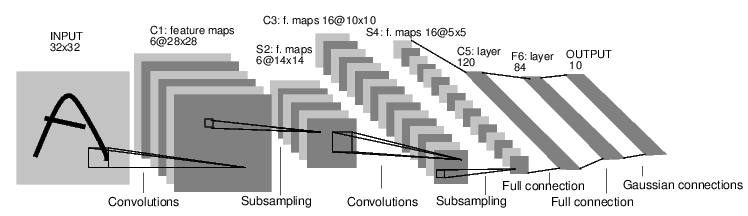

In [ ]:
# 예시는 사진 입력을 받고, 몇 개의 층에 전방 전파하면서 분류를 출력함
# 출력을 위해서 모델은 다음과 같은 학습을 수행함
# - 신경망은 학습가능한 매개변수들(가중치들)을 가짐
# - 사진 데이터를 반복적으로 입력함
# - 신경망을 통해 입력을 처리함(전방 전파)
# - 손실(오차)를 계산함(실제 출력과 예측 출력을 비교하여 학습의 올바름을 판단함)
# - 오차로부터 그레이디언트(경사, 방향)을 신경망의 각 매개변수에서 역전파함(오류 역전파)
# - 신경망의 매개변수들을 갱신함((미래) 가중치 = (현재) 가중치 - 학습률 * 그레이디언트)

# 위의 컨볼루션 신경망의 부분들을 torch를 통해서 손쉽게 구현할 수 있음
# 단지 forward 함수만 정의하면, autograd를 이용해 해당 연산 그래프의 그레이디언트를 구하는 backward는 자동적으로 정의됨
# forward 함수는 Tensor를 이용할 수 있는 다양한 연산들(합, 곱 등등)을 사용하여 정의 가능함
# torch.Tensor: 자동 미분 기능을 지원하는 다차원 배열로 각 Tensor에 해당하는 그레이디언트를 가짐
# nn.Module: 신경망 모듈이며 매개변수의 캡슐화, GPU 연산 등 작업을 쉽게 가능하게 함
# nn.Parameter: 모듈이 지정되면 매개변수들을 자동으로 관리하는 Tensor의 하나임

In [ ]:
# 관련 라이브러리 import
import torch
import torch.nn as nn
import torch.nn.functional as F

# AlexNet의 클래스를 구현하는 코드로, 모든 신경망 모듈의 기반 클래스인 nn.Module을 상속 받아 신경망을 사용한다.
class Net(nn.Module):
  # AlexNet 모델의 초기 생성자를 정의한다.
  def __init__(self):
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5*5 square convolution kernel
    self.conv1 = nn.Conv2d(1, 6, 5)  # 첫번째 CNN을 정의한다.
                                     # 흑백 이미지는 1채널이므로 1을 입력한다.
                                     # 이미지 하나를 입력 받아 6개 채널의 특징맵을 출력한다.
                                     # 5 * 5 사이즈의 커널을 사용한다.
    self.conv2 = nn.Conv2d(6, 16, 5) # 두번째 CNN을 정의한다.
                                     # 6개 채널의 특징맵에서 16개 채널의 특징맵을 출력한다.
                                     # 5 * 5 사이즈의 커널을 사용한다.
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # conv2층에서 출력된 특징맵은 16채널의 5*5 사이즈 이므로
                                          # 이를 완전연결층의 입력으로 하고, 120개의 특징값을 출력한다.
    self.fc2 = nn.Linear(120, 84)         # 두번째 완전연결층을 정의한다.
    self.fc3 = nn.Linear(84, 10)          # 세번째 완전연결층을 정의한다.
  
  # 전방 전파 메서드를 정의한다.
  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 데이터를 첫번째 CNN층에 입력하고 relu 함수에 통과시킨 후
                                                    # 2 * 2 사이즈의 커널을 사용하여 최대 풀링을 적용한다.
    # If the size is a square you can only specify a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), (2))    # 특징맵를 두번째 CNN층에 입력하고 relu 함수에 통과시킨 후
                                                    # 2 * 2 사이즈의 커널을 사용하여 최대 풀링을 적용한다.
    x = x.view(-1, self.num_flat_features(x))       # 특징맵를 완전연결층에 입력하기 전에 flatten 시켜준다.
    x = F.relu(self.fc1(x))                         # 특징값을 첫번째 완전연결층에 입력하고 relu 함수에 통과시킨다.
    x = F.relu(self.fc2(x))                         # 특징값을 두번째 완전연결층에 입력하고 relu 함수에 통과시킨다.
    x = self.fc3(x)                                 # 특징값을 세번째 완전연결층에 입력한다.
    return x                                        # 완전연결층에서 출력된 특징값을 리턴한다.
  
  # 특징맵을 flatten 시키기 위해 flatten 시켰을 때의 크기를 리턴해주는 함수를 정의한다.
  def num_flat_features(self, x):
    size = x.size()[1:] # x 크기의 첫번째 인자는 미니배치의 크기이므로 이를 제외하고 특징맵의 차원
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

# AlexNet 객체를 생성한다.
net = Net()
print(net)

# (1) 정의된 컨볼루션 신경망의 구조 설명(위의 AlexNet 그림 참고

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- 출력된 컨볼루션 신경망의 출력을 확인해보면, 먼저 이미지가 첫번째 CNN을 통과하면 6채널의 28*28 크기의 특징맵이 되고, 이를 relu 함수에 통과시킨다.
- 6 * 28 * 28의 특징맵이 2 * 2 크기의 커널을 사용하는 Max 풀링층을 통과하면 크기가 반으로 줄어 6 * 14 * 14의 특징맵이 된다.
- 이를 두번째 CNN에 통과시키면 16채널의 10*10 크기의 특징맵이 되고 이를 relu 함수에 통과시킨다.
- 16 * 10 * 10의 특징맵이 2 * 2 크기의 커널을 사용하는 Max 풀링틍을 통과하면 16 * 5 * 5의 특징맵이 된다.
- 완전연결층에 특징맵을 입력하기 전에 특징맵을 먼저 flatten 시키면 16 * 5 * 5 = 400 크기의 특징벡터가 된다.
- 이를 첫번째 완전연결층에 통과시키면 120 크기의 특징벡터가 되고 이를 relu 함수에 통과시킨다.
- 120 크기의 특징벡터를 두번째 완전연결층에 통과시키면 84 크기의 특징벡터가 되고 이를 relu 함수에 통과시킨다.
- 84 크기의 특징벡터를 세번째 완전연결층에 통과시키면 10 크기의 특징벡터가 되고 이를 리턴한다.
- AlexNet은 0부터 9까지 총 10개 클래스를 구분하는 신경망으로, 최종 출력의 특징벡터 크기 또한 10인 것을 확인할 수 있다.

In [ ]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's weight

# (2) 화면 출력 확인

10
torch.Size([6, 1, 5, 5])


- 첫번째 출력값은 모델의 매개변수의 모든 층에 대한 길이를 나타낸다.
- 신경망의 은닉층이 5층인데 길이가 10인 이유는 5개의 은닉층에 대한 weights와 bias가 따로 입력되어 있기 때문이다.
- 두번째 출력값은 첫번째 CNN에서 사용하는 커널의 크기를 나타낸다.
- 6채널의 특징맵을 출력해야 하므로 1채널의 5 * 5 크기의 6개 커널을 사용하는 것을 알 수 있다. 

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

# (3) 화면 출력 확인

tensor([[ 0.0585,  0.0484, -0.0730,  0.0203, -0.0422,  0.0716,  0.0251,  0.0434,
          0.0188, -0.0132]], grad_fn=<AddmmBackward>)


- 위의 코드는 신경망에 입력이 가능한 크기의 임의의 난수로 입력 데이터를 생성하여 신경망에 통과시키는 과정이다.
- 1장의 1채널 32*32 크기의 이미지와 같은 텐서를 생성하여 신경망에 통과시킨다.
- 출력 결과를 보면, out은 10개의 클래스에 해당하는 값들을 각각 출력하는 것을 알 수 있다.

In [ ]:
# 오류역전파를 통해 그레이디언트를 구하기 전에 모든 가중치의 그레이디언트 버퍼들을 초기화
net.zero_grad()                  # 모델의 그레디언트를 초기화한다.
out.backward(torch.randn(1, 10)) # 임의의 난수값에 대해 out의 그레디언트를 계산한다.

# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE를 사용
output = net(input)         # (3)과 동일한 input을 신경망에 통과시켜 output을 계산한다.
target = torch.randn(10)    # 예를 들기 위해서 임의의 난수로 target을 정의하고,
target = target.view(1, -1) # output과 동일한 크기로 변환한다.
criterion = nn.MSELoss()    # MSELoss로 손실함수를 정의한다.

loss = criterion(output, target) # 손실함수에 예측값과 실제값을 입력하여 loss를 계산한다.
print(loss)

# (4) 화면 출력 확인

tensor(1.2601, grad_fn=<MseLossBackward>)


- 위의 출력 결과는 MSE loss를 사용하였을 때 예측값과 실제값 사이의 loss를 계산한 것으로, 추후 loss의 그레디언트를 계산하기 위한 grad_fn이 MseLoss로 입력된 것도 확인할 수 있다.


In [ ]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그레이디언트를 초기화해야 함
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함

# 아래의 코드에서는 backward()를 수행하기 전에 모든 파라미터의 그레디언트를 초기화한다.
net.zero_grad() # zeroes the gradient buffers of all parameters
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

# 아래의 코드에서는 loss에 대해 backward() 연산을 수행하여 모든 파라미터에 대해 그레디언트를 계산한다.
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

# (5) backward 전, 후 화면 출력 확인

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0057, -0.0009,  0.0090,  0.0180,  0.0192,  0.0118])


- 출력 결과를 보면, backward()를 수행하기 전에 모든 파라미터의 그레디언트를 초기화하였으므로 첫번째 conv층의 bias의 그레디언트 또한 모두 0으로 초기화된 것을 알 수 있다.
- backward()를 수행하면 모든 파라미터의 그레디언트가 계산되므로 첫번째 conv층의 bias의 그레디언트 또한 loss를 기준으로 계산되어 있는 것을 알 수 있다.

In [ ]:
# 스토캐스틱 경사하강법((미래) 가중치 = (현재) 가중치 - 학습률 * 그레이디언트)을 이용하여
# 가중치 갱신하는 코드는 다음과 같음
learning_rate = 0.01
# 반복문을 통해 모든 가중치를 학습률과 그레디언트를 이용하여 갱신한다.
for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)

# 하지만 위 구현 코드보다 실제, torch.optim에서 구현되는 SGD, Adam, RMSProp 등을 사용함
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드
import torch.optim as optim

# create your optimizer
# SGD optimizer에 신경망의 파라미터를 입력하고 학습률을 지정하여 optimizer 객체를 생성한다.
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
# 가중치를 학습시킬 때에는 먼저 계산된 모든 그레디언트를 초기화한다.
# 그리고 입력 데이터를 신경망에 전방 전파하여 예측값(output)을 계산한다.
# 계산된 예측값과 실제값을 손실함수에 입력하여 loss를 계산한다.
# loss에 대해 오류를 역전파하고 optimizer.step()을 통해
# 계산된 그레디언트로 모든 가중치를 갱신한다.
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update

### 3. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

In [ ]:
# 1번의 기초적인 신경망을 통해서 사진 분류기를 학습함
# 데이터집합 CIFAR-10이며, 아래의 예와 같이 10가지의 3(R, G, B) 채널의 32*32 크기의 사진으로 구성됨

> 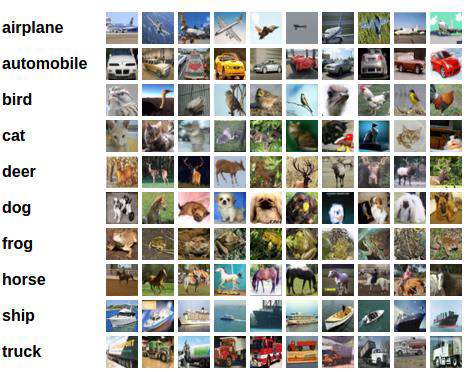

In [ ]:
# CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함
# 분류기 학습은 다음과 같은 과정을 가짐
# 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
# 2. 컨볼루션 신경망을 정의함
# 3. 손실함수 정의
# 4. 훈련집합을 이용하여 신경망을 학습시킴
# 5. 테스트집합을 이용하여 신경망 성능 확인

### 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
# 관련 라이브러리 import
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터를 전처리하기 위한 코드로, transforms의 Compose로 전처리 과정에 포함시킬 인자를 지정한다.
# transforms.ToTensor()로 데이터를 텐서로 변환하고, transforms.Normalize()에 평균((0.5, 0.5, 0.5))과
# 표준편차((0.5, 0.5, 0.5))를 입력하여 정규화한다.
# CIFAR-10의 이미지는 3채널의 이미지이므로 각각의 채널에 대한 평균과 표준편차 값을 입력한다.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# torchvision.datasets으로 CIFAR-10 데이터셋을 불러온다.
# train=True, download=True로 지정하여 훈련 데이터셋을 지정 경로로 다운로드하여 불러온다.
# transform 파라미터를 통해 데이터셋을 전처리한다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# torch.utils.data.DataLoader로 데이터셋을 미니배치 단위로 매 에포크마다 데이터셋을 무작위로 섞으며 불러온다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# train=False, download=True로 지정하여 테스트 데이터셋을 지정 경로로 다운로드하여 불러온다.
# transform 파라미터를 통해 데이터셋을 전처리한다.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# torch.utils.data.DataLoader로 데이터셋을 미니배치 단위로 매 에포크마다 데이터셋을 무작위로 섞으며 불러온다.
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

# 10개의 클래스 명을 tuple로 정의한다.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# (1) 화면 출력 확인

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- 위의 출력을 보면 CIFAR-10 데이터셋이 다운로드되어 지정된 경로에 저장되는 것을 알 수 있다.

  cat  car deer deer


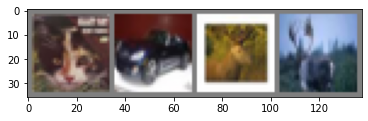

In [ ]:
# 훈련집합의 일부 사진들 확인
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
  img = img / 2 + 0.5 # 이미지를 전처리하기 전 이미지로 재변환하기 위해 표준편차를 곱하고 평균을 더해준다.
  npimg = img.numpy()
  # npimg의 shape은 (3, 36, 128)이므로 이를 RGB 이미지에 맞게 transpose해주어야 한다.
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
# iterator를 통해 미니배치 단위로 이미지를 불러온다.
dataiter = iter(trainloader)
# 이미지와 이미지에 해당하는 label을 각각 입력한다.
images, labels = dataiter.next()

# show images
# torchvision.utils.make_grid는 이미지 간 그리드를 그려준다.
imshow(torchvision.utils.make_grid(images))
# print labels
# 이미지에 대한 label을 출력한다.
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

# (2) 화면 출력 확인

- 위의 출력 결과를 보면, 각각의 이미지와 이미지의 클래스에 해당하는 label이 잘 매칭되는 것을 알 수 있다.

In [ ]:
### 2. 컨볼루션 신경망을 정의함
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행
import torch.nn as nn
import torch.nn.functional as F

# AlexNet의 클래스를 구현하는 코드로, 모든 신경망 모듈의 기반 클래스인 nn.Module을 상속 받아 신경망을 사용한다.
class Net(nn.Module):
  # AlexNet 모델의 초기 생성자를 정의한다.
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)   # 첫번째 CNN을 정의한다.
                                      # RGB 이미지는 3채널이므로 3을 입력한다.
                                      # 이미지 하나를 입력 받아 6개 채널의 특징맵을 출력한다.
                                      # 5 * 5 사이즈의 커널을 사용한다.
    self.pool = nn.MaxPool2d(2, 2)    # Max 풀링층을 정의한다.
                                      # 2 * 2 사이즈의 커널을 사용하여 최대 풀링을 적용한다.
    self.conv2 = nn.Conv2d(6, 16, 5)  # 두번째 CNN을 정의한다.
                                      # 6개 채널의 특징맵에서 16개 채널의 특징맵을 출력한다.
                                      # 5 * 5 사이즈의 커널을 사용한다.
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # conv2층에서 출력된 특징맵은 16채널의 5*5 사이즈 이므로
                                          # 이를 완전연결층의 입력으로 하고, 120개의 특징값을 출력한다.
    self.fc2 = nn.Linear(120, 84)         # 두번째 완전연결층을 정의한다.
    self.fc3 = nn.Linear(84, 10)          # 세번째 완전연결층을 정의한다.

  # 전방 전파 메서드를 정의한다.
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) # 데이터를 첫번째 CNN층에 입력하고 relu 함수에 통과시킨 후
                                         # 2 * 2 사이즈의 커널을 사용하여 최대 풀링을 적용한다.
    x = self.pool(F.relu(self.conv2(x))) # 특징맵를 두번째 CNN층에 입력하고 relu 함수에 통과시킨 후
                                         # 2 * 2 사이즈의 커널을 사용하여 최대 풀링을 적용한다.
    x = x.view(-1, 16*5*5)               # 특징맵를 완전연결층에 입력하기 전에 flatten 시켜준다.
    x = F.relu(self.fc1(x))              # 특징값을 첫번째 완전연결층에 입력하고 relu 함수에 통과시킨다.
    x = F.relu(self.fc2(x))              # 특징값을 두번째 완전연결층에 입력하고 relu 함수에 통과시킨다.
    x = self.fc3(x)                      # 특징값을 세번째 완전연결층에 입력한다.
    return x                             # 완전연결층에서 출력된 특징값을 리턴한다.
  
net = Net() # AlexNet 객체를 생성한다.

### 3. 손실함수 정의, 교차 엔트로피와 SGD + momentum

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss로 손실함수를 정의한다.
# SGD optimizer에 신경망의 파라미터를 입력하고 학습률과 모멘텀을 지정하여 optimizer 객체를 생성한다.
# 모멘텀은 과거의 그레디언트를 이용하여 그레디언트에 부드러움을 가하고 잡음을 줄이는 역할을 한다.
# mementum 파라미터에 입력하는 값은 과거의 그레디언트에 대한 비율을 의미한다.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 훈련집합을 이용하여 신경망을 학습시킴
net.train() # 모델을 훈련 모드로 설정한다.

losses = [] # 문제 5에서 loss 비교를 위한 리스트이다.

# 총 5 epoch만큼 모델을 학습시킨다.
for epoch in range(5): # loop over dataset multiple times
  running_loss = 0.0 # 미니배치 단위로 모델을 학습시킬 때마다 계산된 loss를 누적시키기 위한 변수이다.

  # 미니배치 단위로 데이터를 불러와 for문을 통해 모델을 학습시킨다.
  for i, data in enumerate(trainloader, 0):
    # 미니배치 단위로 데이터에 대한 특징벡터와 레이블로 분리한다.
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)             # 특징벡터를 신경망에 전방 전파하여 예측값(output)을 계산한다.
    loss = criterion(outputs, labels) # 계산된 예측값과 레이블을 손실함수에 입력하여 loss를 계산한다.
    loss.backward()                   # loss에 대해 오류를 역전파한다.
    optimizer.step()                  # 계산된 그레디언트로 모든 가중치를 갱신한다.

    # print statistics
    running_loss += loss.item() # 미니배치마다 계산된 loss를 누적한다.
    if i % 1000 == 999:         # print every 1000 mini-batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
      losses.append(running_loss / 1000) # 문제 5에서 loss 비교를 위한 코드이다.
      running_loss = 0.0                 # 1000개의 미니배치마다 누적된 loss를 초기화한다.

print('Finished Training')
# (3) 화면 출력 확인 및 학습이 되고 있는지 서술

[1,  1000] loss: 2.297
[1,  2000] loss: 2.122
[1,  3000] loss: 1.916
[1,  4000] loss: 1.781
[1,  5000] loss: 1.724
[1,  6000] loss: 1.671
[1,  7000] loss: 1.638
[1,  8000] loss: 1.557
[1,  9000] loss: 1.528
[1, 10000] loss: 1.511
[1, 11000] loss: 1.505
[1, 12000] loss: 1.443
[2,  1000] loss: 1.419
[2,  2000] loss: 1.388
[2,  3000] loss: 1.390
[2,  4000] loss: 1.381
[2,  5000] loss: 1.340
[2,  6000] loss: 1.318
[2,  7000] loss: 1.299
[2,  8000] loss: 1.321
[2,  9000] loss: 1.304
[2, 10000] loss: 1.302
[2, 11000] loss: 1.286
[2, 12000] loss: 1.302
[3,  1000] loss: 1.225
[3,  2000] loss: 1.214
[3,  3000] loss: 1.194
[3,  4000] loss: 1.215
[3,  5000] loss: 1.205
[3,  6000] loss: 1.203
[3,  7000] loss: 1.190
[3,  8000] loss: 1.175
[3,  9000] loss: 1.212
[3, 10000] loss: 1.185
[3, 11000] loss: 1.177
[3, 12000] loss: 1.174
[4,  1000] loss: 1.099
[4,  2000] loss: 1.127
[4,  3000] loss: 1.085
[4,  4000] loss: 1.119
[4,  5000] loss: 1.129
[4,  6000] loss: 1.099
[4,  7000] loss: 1.097
[4,  8000] 

- CIFAR-10 데이터셋의 훈련집합에는 총 60,000개의 이미지가 저장되어 있고, 앞서 미니배치의 크기를 4로 지정하였기 때문에 미니배치의 총 갯수는 60,000 / 4 = 12,000개이다.
- 출력된 결과를 보면, 매 epoch마다 12000개의 미니배치가 학습된 것을 알 수 있다.
- 또한, 모델의 loss를 전체적으로 보았을 때 훈련이 진행될수록 감소하므로 학습이 제대로 진행되었고 모델의 성능이 점진적으로 개선되었음을 알 수 있다.

Ground Truth:  plane deer  dog ship


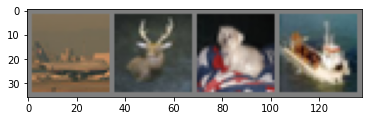

In [ ]:
### 5. 테스트집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader)      # iterator를 통해 미니배치 단위로 이미지를 불러온다.
images, labels = dataiter.next() # 이미지와 이미지에 해당하는 label을 분리한다.

# print images
# 미니배치의 이미지와 label을 아래와 같이 출력한다.
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ''.join('%5s' % classes[labels[j]] for j in range(4)))
# (4) 화면 출력 확인

- 위에 출력된 이미지와 label은 모델을 제대로된 결과를 예측하는지 테스트하기 위한 미니배치 샘플이다.

In [ ]:
net.eval() # 모델을 테스트 모드로 설정한다.
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ''.join('%5s' % classes[predicted[j]] for j in range(4)))

# (5) 화면 출력 확인

Predicted:   ship deer  dog ship


- 위의 출력 결과는 테스트 샘플을 모델에 통과시켜 예측한 결과를 나타낸다.
- 하나의 미니배치로 테스트한 결과 총 4장의 이미지 중 3장의 이미지에 대해 정확히 클래스를 예측한 것을 알 수 있다.

In [ ]:
# performance on the whole test dataset
correct = 0 # 올바르게 예측된 샘플 수를 누적시키기 위한 변수를 초기화한다.
total = 0   # 각 미니배치의 총 샘플 수를 누적시키기 위한 변수를 초기화한다.
# 모델을 테스트할 때는 그레디언트를 추적하지 않아도 되므로 no_grad()를 사용한다. 
with torch.no_grad():
  for data in testloader:
    images, labels = data
    output = net(images)  # 이미지에 대한 예측값을 계산한다.
    _, predicted = torch.max(output.data, 1)      # 10개의 클래스에 대한 확률값 중 가장 큰 값이
                                                  # 모델이 예측한 클래스가 되므로 해당 클래스의 인덱스를 구한다.
    total += labels.size(0)                       # 전체 테스트 샘플의 수를 계산한다.
    correct += (predicted == labels).sum().item() # 모델이 올바르게 예측한 샘플의 수를 계산한다.

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# (6) 화면 출력 확인 및 일반화 성능 서술

Accuracy of the network on the 10000 test images: 60 %


- 위의 결과는 전체 테스트 데이터셋을 모델에 통과시켜 얻은 모델 예측의 정확도이다.
- 모델의 예측 정확도는 약 60%로 비교적 높지 않은 일반화 성능을 가진다.
- 모델이 과소적합된 것인지 과대적합된 것인지를 알기 위해서는 훈련을 진행할 때 동시에 테스트 데이터셋에 대해서 loss를 계산해보아야 한다.
- 모델의 훈련시 loss와 테스트시 loss가 모두 높다면 이는 모델이 훈련 데이터셋에 과소적합된 것으로 예상할 수 있다.
- 모델의 훈련시 loss는 낮고 테스트시 loss만 높다면 이는 모델이 훈련 데이터셋에 과대적합된 것으로 예상할 수 있다.

In [ ]:
# performance on each class
# 클래스 별로 정확히 예측된 샘플의 갯수를 누적하기 위한 리스트를 초기화한다.
class_correct = list(0. for i in range(10))
# 클래스 별로 전체 샘플의 갯수를 세기 위한 리스트를 초기화한다.
class_total = list(0. for i in range(10))

accuracies = [] # 문제 5를 위한 리스트이다.

# 모델을 테스트할 때는 그레디언트를 추적하지 않아도 되므로 no_grad()를 사용한다.
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images) # 이미지에 대한 예측값을 계산한다.
    _, predicted = torch.max(outputs, 1) # 10개의 클래스에 대한 확률값 중 가장 큰 값이
                                         # 모델이 예측한 클래스가 되므로 해당 클래스의 인덱스를 구한다.
    c = (predicted == labels).squeeze()  # 모델이 정확히 예측한 샘플을 boolean 값으로 리턴한다.

    # 모델이 정확히 예측한 샘플 갯수와 미니배치 당 샘플의 갯수를 세기 위한 반복문이다.
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item() # 실제값에 해당하는 인덱스에 올바르게 예측된 샘플 갯수를 더한다.
      class_total[label] += 1             # 미니배치에서 각 클래스에 해당하는 샘플의 갯수를 더한다.

# 각각의 클래스 별로 모델 예측의 정확도를 출력한다.
for i in range(10):
  print('Accuracy of %5s: %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))
  accuracies.append(100 * class_correct[i] / class_total[i])

# (7) 화면 출력 확인 및 부류별 분류기의 성능 서술

Accuracy of plane: 65 %
Accuracy of   car: 68 %
Accuracy of  bird: 43 %
Accuracy of   cat: 36 %
Accuracy of  deer: 50 %
Accuracy of   dog: 64 %
Accuracy of  frog: 65 %
Accuracy of horse: 65 %
Accuracy of  ship: 80 %
Accuracy of truck: 64 %


- 위의 출력은 각각의 클래스에 대한 모델의 정확도를 나타낸다.
- 값을 살펴보면, ship 클래스의 경우 80%의 높은 정확도를 가지며 상대적으로 좋은 성능을 내는 것을 알 수 있다.
- plane, car, deer, dog, frog, horse, truck 클래스의 경우 50% 이상 70% 이하의 정확도를 가지며 절반 이상은 올바르게 예측할 수 있는 성능을 내는 것을 알 수 있다.
- 반면, bird와 cat 클래스의 경우 50% 이하의 비교적 낮은 정확도를 가지며 성능이 좋지 못한 것을 알 수 있다.

### 4. 컨볼루션 층의 입력 크기가 32 * 32 * 3이고, (a) 10개 5 * 5 필터들을 보폭 1과 덧대기 2로 적용하였을 때 출력의 크기와 매개변수의 수를 구하세요. (b) 동일한 입력에 64개 3 * 3 필터들을 보폭 1과 덧대기 1로 적용하였을 때 출력의 크기와 매개변수의 수도 구하세요.

- 입력의 크기가 w1 * h1 * c1인 입력 데이터에 k개의 f * f 필터를 보폭 s와 덧대기 p로 적용하였을 때의 출력의 폭은 w2 = (w1 - f + 2 * p) / s + 1이고 출력의 높이는 h2 = (h1 - f + 2 * p) / s + 1, 출력의 채널 수는 c2 = k 이므로 출력의 크기는 w2 * h2 * c2가 된다. 또한, 커널마다 f * f * c1개의 가중치와 1개의 bias를 가지므로 전체 매개변수의 수는 (f * f * c1 + 1) * k가 된다. 따라서 아래의 문제의 답을 구하면 다음과 같다.

  (a) 출력의 크기: w2 * h2 * c2 = (32 - 5 + 2 * 2) / 1 + 1

In [ ]:
# (a)
w2 = int((32 - 5 + 2 * 2) / 1 + 1)
h2 = int((32 - 5 + 2 * 2) / 1 + 1)
c2 = 10
print(f"(a)\n출력의 크기: {w2} * {h2} * {c2}")
p = int((5 * 5 * 3 + 1) * 10)
print(f"전체 매개변수의 수: {p}")

(a)
출력의 크기: 32 * 32 * 10
전체 매개변수의 수: 760


In [ ]:
# (b)
w2 = int((32 - 3 + 2 * 1) / 1 + 1)
h2 = int((32 - 3 + 2 * 1) / 1 + 1)
c2 = 64
print(f"(b)\n출력의 크기: {w2} * {h2} * {c2}")
p = int((3 * 3 * 3 + 1) * 64)
print(f"전체 매개변수의 수: {p}")

(b)
출력의 크기: 32 * 32 * 64
전체 매개변수의 수: 1792


### 5. 다음 조건을 만족하는 컨볼루션 신경망을 구현하고, 3번의 (3), (6), (7)의 성능 결과를 확인하고 비교하세요.
(1) INPUT-CONV(output_channel=32, kernel_size=(3 * 3)-CONV(32,3 * 3)-RELU-POOL-CONV(32,3 * 3)-CONV(32, 3 * 3)-RELU-MAXPOOL-FC-OUTPUT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time
from tqdm import tqdm

In [ ]:
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.pool = nn.AvgPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 32, 3)
    self.conv4 = nn.Conv2d(32, 32, 3)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32*5*5, 10)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv3(x)
    x = self.max_pool(F.relu(self.conv4(x)))
    x = x.view(-1, 32*5*5)
    x = self.fc1(x)
    return x

net1 = Net1().cuda()

In [ ]:
losses1 = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr = 0.001, momentum=0.9)

net1.train()
for epoch in tqdm(range(5)):
  time.sleep(0.5)
  
  running_loss = 0
  for i, data in enumerate(trainloader):
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    optimizer.zero_grad()
    outputs = net1(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      losses1.append(running_loss / 1000)
      running_loss = 0.0
print('Finished Training')

100%|██████████| 5/5 [08:02<00:00, 96.48s/it]

Finished Training


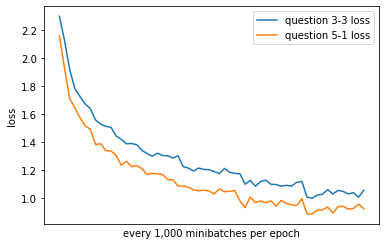

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses1, label='question 5-1 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (1)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-1의 모델이 3-3의 모델보다 CNN층을 2층 더 사용하고, fc층은 2층 적게 사용한 결과로 loss가 작으며 훈련 결과가 더 좋은 것을 알 수 있다.

In [ ]:
net1.eval()
correct1 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net1(images)
    _, predicted = torch.max(outputs.data, 1)
    correct1 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-1: %d %%' % (100 * correct1 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-1: 66 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (1)의 정확도가 66%로 높으며 일반화 성능이 개선된 것을 알 수 있다.

In [ ]:
class_correct1 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies1 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net1(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct1[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct1, cls_total in zip(classes, class_correct1, class_total):
  accuracy = 100 * cls_correct1 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies1.append(accuracy)

Accuracy of plane: 68%
Accuracy of car  : 86%
Accuracy of bird : 47%
Accuracy of cat  : 55%
Accuracy of deer : 53%
Accuracy of dog  : 58%
Accuracy of frog : 81%
Accuracy of horse: 67%
Accuracy of ship : 82%
Accuracy of truck: 70%


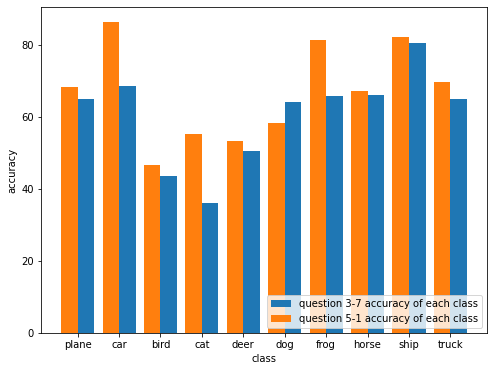

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)
plt.bar([x+0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x-0.2 for x in range(10)], class_accuracies1, width=0.4, label='question 5-1 accuracy of each class')
plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (1)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, dog 클래스를 제외한 모든 클래스에 대해서 5-1의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(2) 아래와 같이 채널 수와 깊이를 변경하여 모델을 구성
> module1 = CONV(output_channel=32, kernel_size=3 * 3,padding=1)-BatchNorm-RELU

> module2 = CONV(output_channel=128, kernel_size=3 * 3,padding=1)-BatchNorm-RELU

> INPUT-CONV(32,3 * 3,1)-ReLU-(module1)-MAXPOOL-(module1)-MAXPOOL- CONV(128,3 * 3,1)-ReLU-(module2)-(module2)-(module2)-GlobalAveragePooling- FC(128 * class_number)-OUTPUT

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)

    self.module1 = nn.Sequential(
                      nn.Conv2d(32, 32, kernel_size=3, padding=1),
                      nn.BatchNorm2d(32),
                      nn.ReLU()
    )
    self.module2 = nn.Sequential(
                      nn.Conv2d(128, 128, kernel_size=3, padding=1),
                      nn.BatchNorm2d(128),
                      nn.ReLU()
    )

    self.max_pool = nn.MaxPool2d(2)
    self.glavg_pool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc1 = nn.Linear(128, 128*10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.module1(x)
    x = self.max_pool(x)
    x = self.module1(x)
    x = self.max_pool(x)
    x = F.relu(self.conv2(x))
    x = self.module2(x)
    x = self.module2(x)
    x = self.module2(x)
    x = self.glavg_pool(x)
    x = x.view(-1, 128)
    x = self.fc1(x)
    return x

net2 = Net2().cuda()

In [ ]:
losses2 = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr = 0.001, momentum=0.9)

net2.train()
for epoch in range(5):
  running_loss = 0
  for i, data in enumerate(trainloader):
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    optimizer.zero_grad()
    outputs = net2(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      losses2.append(running_loss / 1000)
      running_loss = 0.0
print('Finished Training')

Finished Training


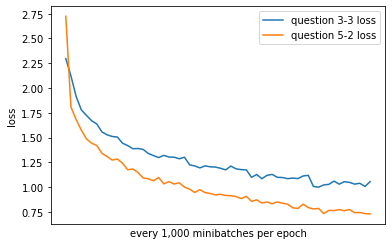

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses2, label='question 5-2 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (2)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-2의 모델이 3-3의 모델보다 훨씬 더 많은 CNN층 사용과 배치 정규화를 하고, 전역 평균 풀링하여 fc층은 줄인 결과로 loss가 훨씬 작으며 훈련 결과가 좋은 것을 알 수 있다.

In [ ]:
net2.eval()
correct2 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net2(images)
    _, predicted = torch.max(outputs.data, 1)
    correct2 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-2: %d %%' % (100 * correct2 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-2: 60 %


- 그러나 위의 결과를 보면, 문제 3의 (6)과 문제 5의 (2)의 정확도가 약 60%로 비슷한 것을 알 수 있다.
- 5-2에서 더 깊은 신경망을 사용하였음에도 일반화 성능은 비슷한 것으로 보아  모델의 용량이 훈련집합보다 커서 훈련집합에 과대적합되었음을 예상할 수 있다.

In [ ]:
class_correct2 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies2 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net2(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct2[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct2, cls_total in zip(classes, class_correct2, class_total):
  accuracy = 100 * cls_correct2 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies2.append(accuracy)

Accuracy of plane: 17%
Accuracy of car  : 98%
Accuracy of bird : 47%
Accuracy of cat  :  8%
Accuracy of deer : 88%
Accuracy of dog  : 83%
Accuracy of frog : 76%
Accuracy of horse: 48%
Accuracy of ship : 64%
Accuracy of truck: 73%


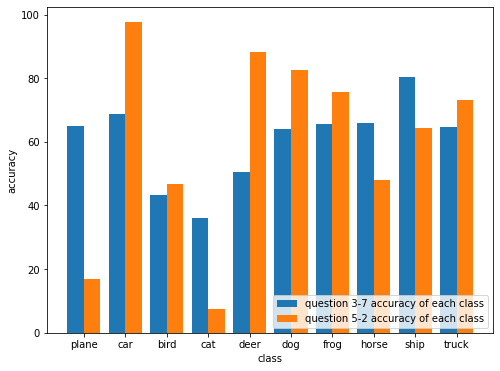

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)
plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies2, width=0.4, label='question 5-2 accuracy of each class')
plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (2)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 6개의 클래스에 대해서 5-2의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(3) 3번 문제의 신경망에 Adam 최적화 (강의자료의 기본 hyper-parameters 사용) 적용

In [ ]:
class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.conv2 = nn.Conv2d(6, 16, 5) 

    self.pool = nn.MaxPool2d(2, 2)    
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16*5*5)  
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))       
    x = self.fc3(x)     
    return x           
  
net3 = Net3().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001, betas=(0.9, 0.999))

net3.train()

losses3 = []
for epoch in range(5):
  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()
    outputs = net3(inputs)          
    loss = criterion(outputs, labels) 
    loss.backward()                 
    optimizer.step()        

    running_loss += loss.item()
    if i % 1000 == 999:    
      losses3.append(running_loss / 1000)
      running_loss = 0.0             

print('Finished Training')

Finished Training


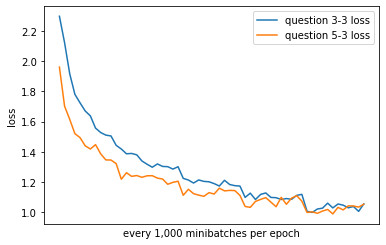

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses3, label='question 5-3 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (3)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-3의 모델의 loss가 훈련 초기에는 3-3의 모델의 loss보다 낮다가 훈련 중반 이후부터 loss가 비슷해지는 것을 알 수 있다.

In [ ]:
net3.eval()
correct3 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net3(images)
    _, predicted = torch.max(outputs.data, 1)
    correct3 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-3: %d %%' % (100 * correct3 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-3: 61 %


- 그러나 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (3)의 정확도가 61%로 높은 것을 알 수 있다.
- 큰 차이는 아니지만, 적응적 학습률과 momemtum을 모두 포함하는 Adam 최적화를 통해 신경망이 기존보다 좋은 성능을 내는 것을 알 수 있다.

In [ ]:
class_correct3 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies3 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net3(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct3[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct3, cls_total in zip(classes, class_correct3, class_total):
  accuracy = 100 * cls_correct3 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies3.append(accuracy)

Accuracy of plane: 61%
Accuracy of car  : 77%
Accuracy of bird : 47%
Accuracy of cat  : 45%
Accuracy of deer : 59%
Accuracy of dog  : 50%
Accuracy of frog : 75%
Accuracy of horse: 59%
Accuracy of ship : 65%
Accuracy of truck: 77%


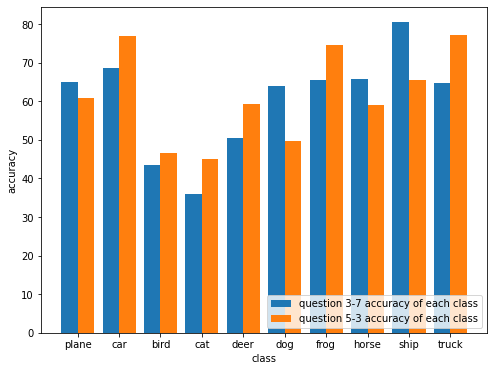

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)
plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies3, width=0.4, label='question 5-3 accuracy of each class')
plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (3)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 6개의 클래스에 대해서 5-3의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(4) 데이터 확대 방법들 중 하나를 적용한 후, 3번 문제의 신경망 학습 (Hint: transforms)

In [ ]:
transform1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                 transforms.Lambda(lambda images: transforms.functional.affine(images, angle=2, translate=(0.5, 0.5), scale=1.2, shear=0))])

trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform1)
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)

trainset_affine = trainset1 + trainset2
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader_affine = torch.utils.data.DataLoader(trainset_affine, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Net4(nn.Module):
  def __init__(self):
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net4 = Net4().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4.parameters(), lr=0.001, momentum=0.9)

net4.train()
losses4 = []
for epoch in tqdm(range(5)):
  time.sleep(0.5)

  running_loss = 0.0

  for i, data in enumerate(trainloader_affine, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()
    outputs = net4(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      losses4.append(running_loss / 2000)
      running_loss = 0.0

print('\nFinished Training')

100%|██████████| 5/5 [15:27<00:00, 185.43s/it]


Finished Training


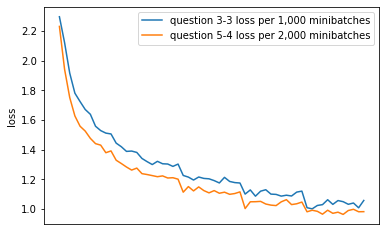

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss per 1,000 minibatches')
plt.plot(range(60), losses4, label='question 5-4 loss per 2,000 minibatches')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (4)의 loss를 비교해놓은 그래프이다.
- 5-4의 훈련집합은 데이터 확대를 통해 크기가 2배가 되었기 때문에 3-3과 달리 2,000개의 미니배치마다 loss를 저장하였다.
- 5-4의 모델이 3-3의 모델보다 2배 많은 훈련집합을 사용하여 1 epoch 당 학습 자체가 2배 많이 되므로 그 결과 loss가 더 작으며 훈련 성능이 좋은 것을 알 수 있다.

In [ ]:
net4.eval()
correct4 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net4(images)
    _, predicted = torch.max(outputs.data, 1)
    correct4 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-4: %d %%' % (100 * correct4 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-4: 62 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (4)의 정확도가 62%로 높으며 일반화 성능이 개선된 것을 알 수 있다.

In [ ]:
class_correct4 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies4 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net4(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct4[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct4, cls_total in zip(classes, class_correct4, class_total):
  accuracy = 100 * cls_correct4 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies4.append(accuracy)

Accuracy of plane: 73%
Accuracy of car  : 79%
Accuracy of bird : 47%
Accuracy of cat  : 45%
Accuracy of deer : 57%
Accuracy of dog  : 48%
Accuracy of frog : 77%
Accuracy of horse: 66%
Accuracy of ship : 80%
Accuracy of truck: 56%


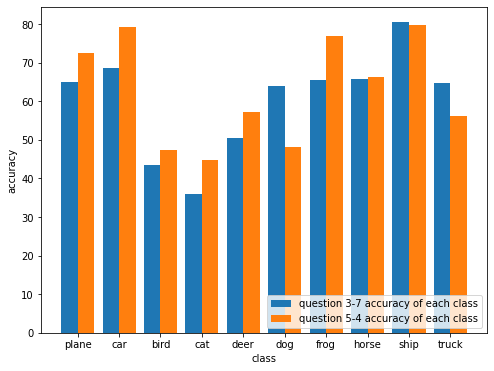

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies4, width=0.4, label='question 5-4 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (4)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 7개의 클래스에 대해서 5-4의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(5) 3번 문제의 신경망에 CONV 층마다 배치 정규화를 적용 (Hint: nn.BatchNorm)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Net5(nn.Module):
  def __init__(self):
    super(Net5, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    
    self.bn1 = nn.BatchNorm2d(6)
    self.bn2 = nn.BatchNorm2d(16)

    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)    
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(-1, 16*5*5)     
    x = F.relu(self.fc1(x))        
    x = F.relu(self.fc2(x))    
    x = self.fc3(x)   
    return x               
  
net5 = Net5().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net5.parameters(), lr=0.001, momentum=0.9)

net.train()

losses5 = []

for epoch in range(5):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()

    outputs = net5(inputs)    
    loss = criterion(outputs, labels)
    loss.backward()   
    optimizer.step()     

    running_loss += loss.item()
    if i % 1000 == 999:       
      losses5.append(running_loss / 1000)
      running_loss = 0.0           

print('Finished Training')

Finished Training


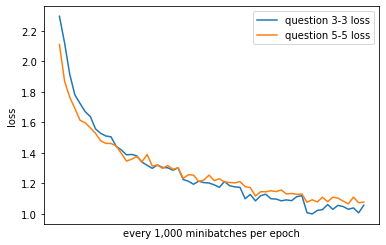

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses5, label='question 5-5 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (5)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-5의 모델의 loss가 훈련 초기에는 3-3의 모델의 loss보다 낮다가 훈련 중반 이후는 거의 비슷하게 감소되는 것을 알 수 있다.

In [ ]:
net5.eval()
correct5 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net5(images)
    _, predicted = torch.max(outputs.data, 1)
    correct5 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-5: %d %%' % (100 * correct5 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-5: 62 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (5)의 정확도가 62%로 높으며 배치 정규화를 통해 일반화 성능이 개선된 것을 알 수 있다.

In [ ]:
class_correct5 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies5 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net5(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct5[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct5, cls_total in zip(classes, class_correct5, class_total):
  accuracy = 100 * cls_correct5 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies5.append(accuracy)

Accuracy of plane: 61%
Accuracy of car  : 77%
Accuracy of bird : 53%
Accuracy of cat  : 40%
Accuracy of deer : 64%
Accuracy of dog  : 46%
Accuracy of frog : 70%
Accuracy of horse: 69%
Accuracy of ship : 83%
Accuracy of truck: 59%


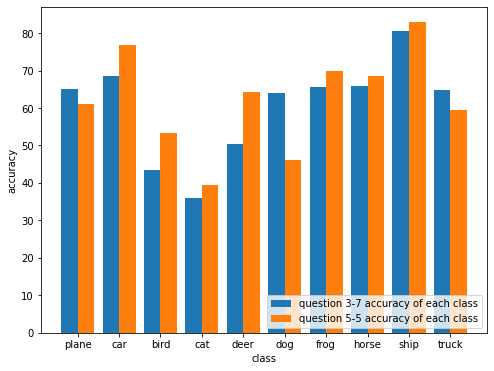

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies5, width=0.4, label='question 5-5 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (5)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 7개의 클래스에 대해서 5-5의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(6) 3번 문제의 신경망 fc2 직후에 dropout(p=0.1) 적용

In [ ]:
class Net6(nn.Module):
  def __init__(self):
    super(Net6, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)    
    self.fc3 = nn.Linear(84, 10) 
    self.fc_drop = nn.Dropout(p=0.1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)     
    x = F.relu(self.fc1(x))        
    x = F.relu(self.fc_drop(self.fc2(x)))
    x = self.fc3(x)   
    return x               
  
net6 = Net6().cuda()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net6.parameters(), lr=0.001, momentum=0.9)

net6.train()

losses6 = []

for epoch in range(5):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    
    optimizer.zero_grad()

    outputs = net6(inputs)    
    loss = criterion(outputs, labels)
    loss.backward()   
    optimizer.step()     

    running_loss += loss.item()
    if i % 1000 == 999:       
      losses6.append(running_loss / 1000)
      running_loss = 0.0           

print('Finished Training')

Finished Training


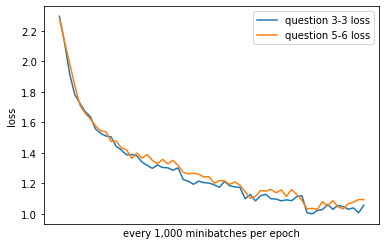

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses6, label='question 5-6 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (6)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-6의 모델의 loss가 3-3의 모델의 loss보다 전반적으로 약간 높은 상태로 감소하는 것을 알 수 있다.

In [ ]:
net6.eval()
correct6 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net6(images)
    _, predicted = torch.max(outputs.data, 1)
    correct6 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-6: %d %%' % (100 * correct6 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-6: 60 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도와 문제 5의 (6)의 정확도는 60%로 드롭아웃을 적용하더라도 모델 예측의 정확도는 비슷한 것을 알 수 있다.

In [ ]:
class_correct6 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies6 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net6(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct6[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct6, cls_total in zip(classes, class_correct6, class_total):
  accuracy = 100 * cls_correct6 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies6.append(accuracy)

Accuracy of plane: 58%
Accuracy of car  : 73%
Accuracy of bird : 46%
Accuracy of cat  : 38%
Accuracy of deer : 65%
Accuracy of dog  : 50%
Accuracy of frog : 60%
Accuracy of horse: 71%
Accuracy of ship : 79%
Accuracy of truck: 66%


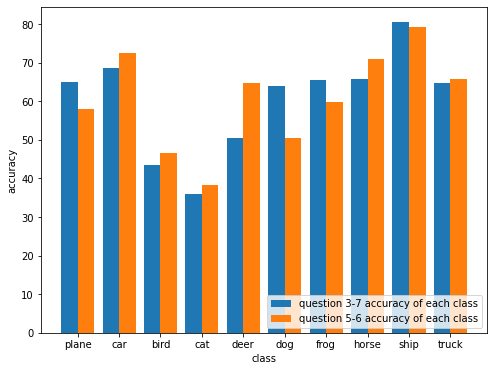

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies6, width=0.4, label='question 5-6 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (6)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 5개의 클래스에 대해서 5-6의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(7) 3번 문제의 신경망 fc layer들에 Xavier initialization 적용 (Hint: nn.init.xavier_uniform_)

In [ ]:
class Net7(nn.Module):
  def __init__(self):
    super(Net7, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)    
    self.fc3 = nn.Linear(84, 10) 
    torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
    torch.nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))
    torch.nn.init.xavier_uniform_(self.fc3.weight)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)     
    x = F.relu(self.fc1(x))        
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x               
  
net7 = Net7().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net7.parameters(), lr=0.001, momentum=0.9)

net7.train()

losses7 = []

for epoch in range(5):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    
    optimizer.zero_grad()

    outputs = net7(inputs)    
    loss = criterion(outputs, labels)
    loss.backward()   
    optimizer.step()     

    running_loss += loss.item()
    if i % 1000 == 999:       
      losses7.append(running_loss / 1000)
      running_loss = 0.0           

print('Finished Training')

Finished Training


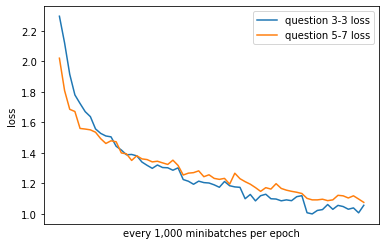

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses7, label='question 5-7 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (7)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-7의 모델의 loss가 훈련 초기에는 3-3의 모델의 loss보다 낮다가 훈련 중반 이후부터 loss가 더 커지는 것을 알 수 있다.

In [ ]:
net7.eval()
correct7 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net7(images)
    _, predicted = torch.max(outputs.data, 1)
    correct7 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-7: %d %%' % (100 * correct7 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-7: 58 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (7)의 정확도가 58%로 Xavier initialization를 수행하면서 오히려 일반화 성능이 떨어지는 것을 알 수 있다.

In [ ]:
class_correct7 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies7 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net7(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct7[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct7, cls_total in zip(classes, class_correct7, class_total):
  accuracy = 100 * cls_correct7 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies7.append(accuracy)

Accuracy of plane: 65%
Accuracy of car  : 63%
Accuracy of bird : 53%
Accuracy of cat  : 60%
Accuracy of deer : 39%
Accuracy of dog  : 34%
Accuracy of frog : 62%
Accuracy of horse: 68%
Accuracy of ship : 71%
Accuracy of truck: 69%


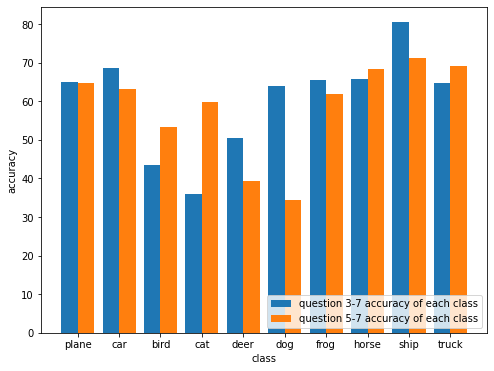

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies7, width=0.4, label='question 5-7 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (7)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 4개의 클래스에 대해서 5-7의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(8) 3번 문제의 신경망에 로그우도 (-log) 손실함수를 적용

In [ ]:
class Net8(nn.Module):
  def __init__(self):
    super(Net8, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)    
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)     
    x = F.relu(self.fc1(x))        
    x = F.relu(self.fc2(x))    
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)   
    return x               
  
net8 = Net8().cuda()

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net8.parameters(), lr=0.001, momentum=0.9)

net8.train()

losses8 = []

for epoch in range(5):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    
    optimizer.zero_grad()

    outputs = net8(inputs)    
    loss = criterion(outputs, labels)
    loss.backward()   
    optimizer.step()     

    running_loss += loss.item()
    if i % 1000 == 999:       
      losses8.append(running_loss / 1000)
      running_loss = 0.0           

print('Finished Training')

Finished Training


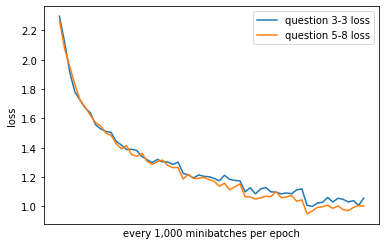

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses8, label='question 5-8 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (8)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-8의 모델의 loss와 3-3의 모델의 loss가 비슷한 형태로 감소하는 것을 알 수 있다.
- 이러한 결과는 CrossEntropy 손실함수와 로그우도 손실함수가 출력하는 결과가 label 값과 label에 해당하는 예측 확률값에 로그를 취한 값을 곱한 형태로 동일하기 때문에 나타나는 것으로 보인다.

In [ ]:
net8.eval()
correct8 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net8(images)
    _, predicted = torch.max(outputs.data, 1)
    correct8 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-8: %d %%' % (100 * correct8 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-8: 63 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (8)의 정확도가 63%로 정확도의 경우 로그우도를 사용하였을 때 약간 높은 것을 알 수 있다.

In [ ]:
class_correct8 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies8 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net8(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct8[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct8, cls_total in zip(classes, class_correct8, class_total):
  accuracy = 100 * cls_correct8 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies8.append(accuracy)

Accuracy of plane: 75%
Accuracy of car  : 80%
Accuracy of bird : 43%
Accuracy of cat  : 31%
Accuracy of deer : 57%
Accuracy of dog  : 64%
Accuracy of frog : 76%
Accuracy of horse: 76%
Accuracy of ship : 76%
Accuracy of truck: 60%


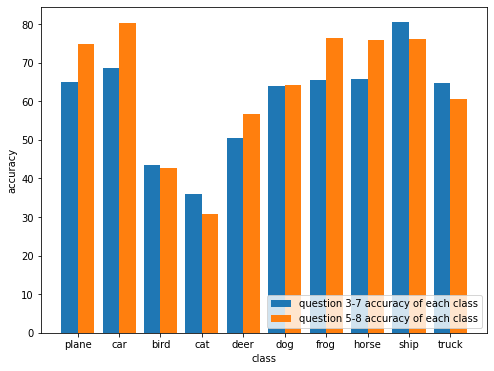

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies8, width=0.4, label='question 5-8 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (8)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 6개의 클래스에 대해서 5-8의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

(9) 3번 문제의 신경망에 L2놈 규제 적용

In [ ]:
class Net9(nn.Module):
  def __init__(self):
    super(Net9, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)    
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)     
    x = F.relu(self.fc1(x))        
    x = F.relu(self.fc2(x))    
    x = self.fc3(x)   
    return x               
  
net9 = Net9().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net9.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

net9.train()

losses9 = []

for epoch in range(5):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    
    optimizer.zero_grad()

    outputs = net9(inputs)    
    loss = criterion(outputs, labels)
    loss.backward()   
    optimizer.step()     

    running_loss += loss.item()
    if i % 1000 == 999:       
      losses9.append(running_loss / 1000)
      running_loss = 0.0           

print('Finished Training')

Finished Training


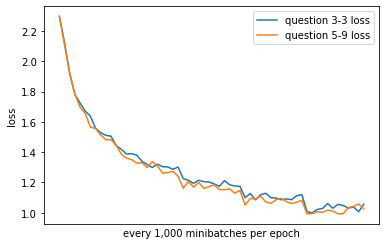

In [ ]:
plt.plot(range(60), losses, label='question 3-3 loss')
plt.plot(range(60), losses9, label='question 5-9 loss')
plt.xlabel('every 1,000 minibatches per epoch')
plt.ylabel('loss')
plt.xticks([])
plt.legend()
plt.show()

- 위의 그래프는 문제 3번의 (3)와 5번의 (9)의 loss를 비교해놓은 그래프이다.
- 그래프 결과를 보면 5-9의 모델의 loss와 3-3의 모델의 loss가 비슷하게 감소하는 것을 알 수 있다.
- 3-3 모델의 경우 모델이 훈련집합에 과대적합되지 않았기 때문에 모델에 규제를 강하게 걸어주지 않아도 되고, 모델에 파라미터값(lambda에 해당)을 높여 규제를 강하게 걸어줄 경우 오히려 loss가 증가하는 경향을 보였다.

In [ ]:
net9.eval()
correct9 = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net9(images)
    _, predicted = torch.max(outputs.data, 1)
    correct9 += (predicted == labels).cpu().sum()

print('The network accuracy of question 3-6: %d %%' % (100 * correct / total))
print('The network accuracy of question 5-9: %d %%' % (100 * correct9 / len(testloader.dataset)))

The network accuracy of question 3-6: 60 %
The network accuracy of question 5-9: 61 %


- 위의 결과를 보면, 문제 3의 (6)의 정확도 60%보다 문제 5의 (9)의 정확도가 61%로 모델에 규제를 가하면서 일반화 성능은 약간 증가한 것을 알 수 있다.

In [ ]:
class_correct9 = list(0. for i in range(10))
class_total = list(0. for i in range(10))

class_accuracies9 = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()

    outputs = net9(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(len(labels)):
      label = labels[i]
      class_correct9[label] += c[i].item()
      class_total[label] += 1

for cls, cls_correct9, cls_total in zip(classes, class_correct9, class_total):
  accuracy = 100 * cls_correct9 / cls_total
  print(f'Accuracy of {cls:5s}: {accuracy:2.0f}%')
  class_accuracies9.append(accuracy)

Accuracy of plane: 67%
Accuracy of car  : 72%
Accuracy of bird : 59%
Accuracy of cat  : 21%
Accuracy of deer : 45%
Accuracy of dog  : 67%
Accuracy of frog : 68%
Accuracy of horse: 69%
Accuracy of ship : 78%
Accuracy of truck: 68%


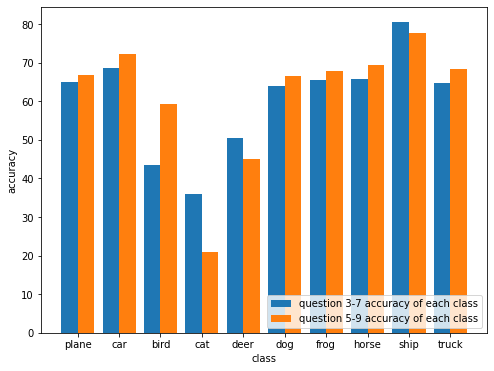

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xticks(range(10))
ax.set_xticklabels(classes)

plt.bar([x-0.2 for x in range(10)], accuracies, width=0.4, label='question 3-7 accuracy of each class')
plt.bar([x+0.2 for x in range(10)], class_accuracies9, width=0.4, label='question 5-9 accuracy of each class')

plt.xlabel('class')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

- 위의 막대 그래프는 문제 3의 (7)과 문제 5의 (9)의 클래스 별 정확도를 시각화한 것이다.
- 그래프를 통해 비교해보면, 7개의 클래스에 대해서 5-9의 정확도가 3-7의 정확도보다 높은 것을 알 수 있다.

### 5. 신경망의 출력이 (0.4,2.0,0.001,0.32)^T일 때 소프트맥스 함수를 적용한 결과를 쓰시오.

In [ ]:
# 입력이 (0.4,2.0,0.001,0.32)^T일 때 소프트맥스 함수를 적용하면 다음과 같다.
V1 = torch.tensor([0.4, 2.0, 0.001, 0.32]).view(-1, 1)
result = torch.exp(V1) / torch.exp(V1).sum()
print([[v.item() for v in result]], '^T')

[[0.1325005292892456, 0.656279444694519, 0.08890662342309952, 0.12231340259313583]] ^T


### 6. 소프트맥스 함수를 적용한 후 출력이 (0.001,0.9,0.001,0.098)^T이고 레이블 정보가 (0,0,0,1)^T일 때 세 가지 목적함수 평균제곱 오차, 교차 엔트로피, 로그우도를 계산하시오

In [ ]:
s = torch.tensor([0.001,0.9,0.001,0.098]).view(-1, 1)
label = torch.tensor([0, 0, 0, 1.0]).view(-1, 1)

### 평균제곱 오차
mse = torch.mean((s - label) ** 2)
print('평균 제곱 오차:', mse.item())

### 교차 엔트로피
crossEntropy = - (torch.log2(s) * label).sum()
print('교차 엔트로피:', crossEntropy.item())

### 로그우도
logLikelyhood = - torch.log2(s[label == 1.0])
print('로그우도: ', logLikelyhood.item())

평균 제곱 오차: 0.4059014916419983
교차 엔트로피: 3.351074457168579
로그우도:  3.351074457168579
